# Cognitive Services > Vision > Form Recognizer > Prebuilt APIs

## 1. Receipt API

In [18]:
# load libraries
import os
import datetime
import json
import pprint

from azure.core.exceptions import ResourceNotFoundError
from azure.ai.formrecognizer import FormRecognizerClient
from azure.core.credentials import AzureKeyCredential

# load API URL & Key from config
config_file = os.path.normpath('C:\CODES_REC\Workshop\CognitiveServices_2021\cognitiveservices_config.json')
with open(config_file, 'r') as j:
     config = json.loads(j.read())

endpoint = config['form.recognizer']['api'] # ex. https://xxxxxxxx.cognitiveservices.azure.com
key = config['form.recognizer']['key'] # ex. 234234werwer23424

In [29]:
def process_image(filepath):
    """ Send image for processing & receive result
    Params:
        filepath (str): path to image
    Returns:
        result (list): data extracted from reciept
    """
    
    try:
        # AUTH
        form_recognizer_client = FormRecognizerClient(endpoint, AzureKeyCredential(key))

        start_dt = datetime.datetime.now()

        with open(filepath, mode='rb') as file:
            poller = form_recognizer_client.begin_recognize_receipts(file.read())
            #poller = form_recognizer_client.begin_recognize_receipts_from_url(receiptUrl)
            
        result = poller.result()

        # result returned by Service
        delta = datetime.datetime.now() - start_dt
        print('Time elapsed: %s' %delta)

    except Exception as e:
        print('ERROR: image processing, %s' %e)
    
    return result

In [20]:
def process_result(result):
    """
    Processes the output of Receipt API
    Params:
        result (list): Receipt API processing result    
    Returns:
        bounding_boxes (list): list of bounding boxes for elements found
    """

    bounding_boxes = []
    data_out = {}

    try:
        for receipt in result:
            print('-RAW DATA-------------------------------------')
            print(receipt)
            print('----------------------------------------------\n')

            for name, field in receipt.fields.items():

                if name == "Items":
                    data_out[name] = {}
                    print("Receipt Items:")
                    for idx, items in enumerate(field.value):
                        data_out[name][idx] = {}
                        print("\tItem #{}".format(idx + 1))
                        for item_name, item in items.value.items():
                            print("\t\t{}: {} has confidence {}".format(item_name, item.value, item.confidence))                                       
                            if getattr(item.value_data, 'bounding_box', False):
                                bounding_boxes.append(item.value_data.bounding_box)

                            data_out[name][idx][item_name] = item.value

                else:
                    if getattr(field.value_data, 'bounding_box', False):
                        # item doesn't have bounding box
                        bounding_boxes.append(field.value_data.bounding_box)
                    if field.value != None:
                        print("{}: {} has confidence {}".format(name, field.value, field.confidence))
                        data_out[name] = field.value
                    else: 
                        # when field value = None, but the text in FieldData is availble, example date time formats
                        print("{}: {} has confidence {} | value found in text attr".format(name, field.value_data.text, 
                                                                                           field.confidence))
                        data_out[name] = field.value_data.text
        print('\n')                
        pprint.pprint(data_out)
    except Exception as e:
        print('ERROR: data post processing, %s' %e)

    # check which fields were found & which were not found
    receipt_fields = ["ReceiptType", "MerchantName", "MerchantPhoneNumber", "MerchantAddress",
                     "TransactionDate", "TransactionTime", "Total", "Subtotal", "Tax", "Tip", "Items" ]
    
    missing_fields = [] # fields not found in receipt
    for f in receipt_fields:
        if not data_out.get(f):
            missing_fields.append(f)
    print('Fields NOT Found: %s' %', '.join(missing_fields))
    
    return bounding_boxes


In [30]:
# Process image
filepath = 'C:\CODES_REC\FormRecognizer\BeaconReceipt_Demo.png'

result = process_image(filepath)
bounding_boxes = process_result(result)

<class 'list'>
Time elapsed: 0:00:06.423962
-RAW DATA-------------------------------------
RecognizedForm(form_type=prebuilt:receipt, fields={'ReceiptType': FormField(value_type=string, label_data=None, value_data=None, name=ReceiptType, value='Itemized', confidence=0.943), 'MerchantName': FormField(value_type=string, label_data=None, value_data=FieldData(page_number=1, text=THE BEACON, bounding_box=[Point(x=243.9, y=195.8), Point(x=603.0, y=186.0), Point(x=604.2, y=229.2), Point(x=245.0, y=238.9)], field_elements=None), name=MerchantName, value='THE BEACON', confidence=0.767), 'TransactionDate': FormField(value_type=date, label_data=None, value_data=FieldData(page_number=1, text=14/11/2020, bounding_box=[Point(x=56.0, y=503.0), Point(x=250.0, y=506.0), Point(x=250.0, y=540.0), Point(x=56.0, y=540.0)], field_elements=None), name=TransactionDate, value=None, confidence=0.914), 'TransactionTime': FormField(value_type=time, label_data=None, value_data=FieldData(page_number=1, text=19:32, 

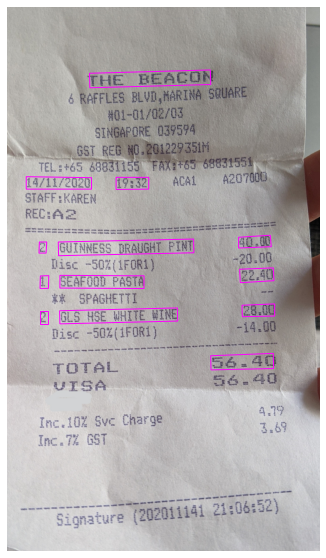

In [28]:
# plot results
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
img = Image.open(filepath)
ax.imshow(img)

# add bounding boxes for the fields found in receipt
for rec in bounding_boxes:
    ax.add_patch(mpatches.Polygon(rec, fill=False, color='magenta'))
    
plt.axis('off')

plt.show()

## 2. Invoice API

In [23]:
try:
    # AUTH
    form_recognizer_client = FormRecognizerClient(endpoint, AzureKeyCredential(key))
    # load data - example local file

    # change filename if needed
    filepath = os.path.normpath('C:\CODES_REC\FormRecognizer\invoice_02.jpg')
    start_dt = datetime.datetime.now()

    with open(filepath, mode='rb') as file:
        poller = form_recognizer_client.begin_recognize_invoices(file.read())

    result = poller.result()

    # result returned by Service
    delta = datetime.datetime.now() - start_dt
    print('Time elapsed: %s' %delta)
    
    print('\n-RAW DATA-------------------------------------')
    print(result)
    print('----------------------------------------------\n')
    
except Exception as e:
    print('ERROR: image processing, %s' %e)


Time elapsed: 0:00:12.589896

-RAW DATA-------------------------------------
[RecognizedForm(form_type=prebuilt:invoice, fields={'CustomerName': FormField(value_type=string, label_data=None, value_data=FieldData(page_number=1, text=SAMPLE INDONESIA, PT., bounding_box=[Point(x=129.0, y=106.0), Point(x=276.0, y=106.0), Point(x=276.0, y=120.0), Point(x=129.0, y=120.0)], field_elements=None), name=CustomerName, value='SAMPLE INDONESIA, PT.', confidence=0.957), 'DueDate': FormField(value_type=date, label_data=None, value_data=FieldData(page_number=1, text=11 February 2013, bounding_box=[Point(x=603.0, y=78.0), Point(x=690.0, y=78.0), Point(x=690.0, y=91.0), Point(x=603.0, y=91.0)], field_elements=None), name=DueDate, value=datetime.date(2013, 2, 11), confidence=0.995), 'InvoiceDate': FormField(value_type=date, label_data=None, value_data=FieldData(page_number=1, text=11 February 2013, bounding_box=[Point(x=601.0, y=46.0), Point(x=690.0, y=46.0), Point(x=690.0, y=60.0), Point(x=601.0, y=60.0

In [24]:
# process result

bounding_boxes = []
data_out = {}

try:
    for inv in result:
        for name, field in inv.fields.items():
            if name == "Items":
                # field is collection of items
                data_out[name] = {}
                print("Receipt Items:")
                for idx, items in enumerate(field.value):
                    data_out[name][idx] = {}
                    print("\tItem #{}".format(idx + 1))
                    for item_name, item in items.value.items():
                        print("\t\t{}: {} has confidence {}".format(item_name, item.value, item.confidence))                                       
                        if getattr(item.value_data, 'bounding_box', False):
                            bounding_boxes.append(item.value_data.bounding_box)
                            
                        data_out[name][idx][item_name] = item.value
             
            else:
                if getattr(field.value_data, 'bounding_box', False):
                    # item doesn't have bounding box
                    bounding_boxes.append(field.value_data.bounding_box)
                if field.value != None:
                    print("{}: {} has confidence {}".format(name, field.value, field.confidence))
                    data_out[name] = field.value
                else: 
                    # when field value = None, but the text in FieldData is availble, example date time formats
                    print("{}: {} has confidence {} | value found in text attr".format(name, field.value_data.text, field.confidence))
                    data_out[name] = field.value_data.text
    print('\n')                
    pprint.pprint(data_out)
    
except Exception as e:
    print('ERROR: data post processing, %s' %e)

CustomerName: SAMPLE INDONESIA, PT. has confidence 0.957
DueDate: 2013-02-11 has confidence 0.995
InvoiceDate: 2013-02-11 has confidence 0.993
InvoiceId: 00000145 has confidence 0.999
InvoiceTotal: 3513.53 has confidence 0.961
SubTotal: 3194.12 has confidence 0.959
TotalTax: 319.41 has confidence 0.999
VendorAddress: Graha Arteri J1. Panjang Blok 101 No.1, Jakarta 12223 has confidence 0.885
VendorAddressRecipient: PT. SAMPLE SARANA ABADI Ruko Mas has confidence 0.772
VendorName: PT. SAMPLE SARANA ABADI Ruko Mas has confidence 0.772


{'CustomerName': 'SAMPLE INDONESIA, PT.',
 'DueDate': datetime.date(2013, 2, 11),
 'InvoiceDate': datetime.date(2013, 2, 11),
 'InvoiceId': '00000145',
 'InvoiceTotal': 3513.53,
 'SubTotal': 3194.12,
 'TotalTax': 319.41,
 'VendorAddress': 'Graha Arteri J1. Panjang Blok 101 No.1, Jakarta 12223',
 'VendorAddressRecipient': 'PT. SAMPLE SARANA ABADI Ruko Mas',
 'VendorName': 'PT. SAMPLE SARANA ABADI Ruko Mas'}


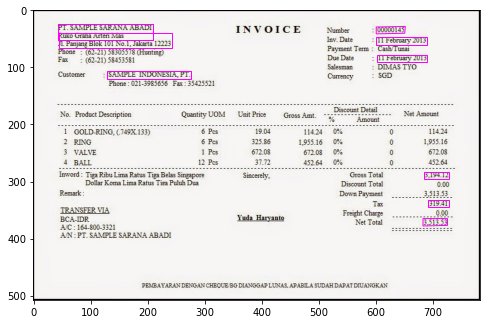

In [25]:
# plot results
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
img = Image.open(filepath)
ax.imshow(img)

# add bounding boxes for the fields found in receipt
for rec in bounding_boxes:
    ax.add_patch(mpatches.Polygon(rec, fill=False, color='magenta'))

plt.show()